## Dev Dashboarding ##
panel serve PHNX_prod_analytics.ipynb --session-token-expiration 600
* https://docs.google.com/document/d/1PU1OUlR6i1fGRnLsv8iYXmmY_byGu2kccWzCMyY922o/edit

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import panel as pn
import pickle
import numpy as np

repo_dir = os.path.dirname(os.getcwd())
if repo_dir not in sys.path: sys.path.append(repo_dir)
mod_dir = f'{os.path.dirname(os.path.dirname(repo_dir))}/analytics_utils/'
if mod_dir not in sys.path: sys.path.append(mod_dir)

from analysis_pipeline.analysis_pipeline import AnalysisPipeline
from analytics_utils.lims_tools.lims_utils import get_plate_runs, plates_from_exp, plates_from_workflow
from analytics_utils.database_access.s3_interface import download_from_s3, upload_to_s3, s3_imgupload, s3_imgdownload, s3_df2csv, s3_csv2df
from analytics_utils.database_access.table_properties import * 
from analytics_utils.analysis_tools.dataset_creation_utils import combine_col_labels
from analytics_utils.visualization_tools.visualization_utils import plot_boxplot

s3_bucket = 'ml-analytics-file-store' 
dataset_folder = '../../../DATASETS/'
figure_folder = '../../../FIGURES/'
pn.extension(sizing_mode="stretch_width")

overall_analytics_panel = []
variant_analytics_panel = []
top_variant_reps = []
top_variant_analytics_panel = []
activity_corr_panel = []
activityCV_corr_panel = []
plate_analytics_panel = []
library_analytics_panel = []
unit_analytics_panel = []

# Get data from table

In [2]:
s3_subfolder = 'VQ-GlycStockMeanShiftCheck/' # 'VQ-GSMS-IPTG-exps/' # 'VQ-all-expts/' # 'VQ-IPTGexp-reanalysis/' # # 'Kwajalein/' # 'VQ-IPTGexp/' # 'VQ-IPTGexp-outliersremoved/' 
exp_workflow = ['WF10215', 'WF10216'] # ['WF10203', 'WF10215', 'WF10216'] # ['WF10191', 'WF10198', 'WF10203', 'WF10215', 'WF10216'] # ['WF10203'] # ['WF10164', 'WF10186', 'WF10210']  # 
table = 'lcms_detections' # 'combi_analytics_table' # 
update_analytics_table = False
metric_dict = {'LcmsC18':['pellet_OD', 'measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)']}
# metric_dict = {'LcmsC18':['measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)'], 'LcmsChiral':['measured_enantiomeric_excess_(+over-)']}
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    metric_dict=metric_dict, 
    get_dashboard_panel=False,
    save_plots_to_s3=True,
    hit_filter_dict = {'measured_nonbinary_score_(r)': 5} # 0.2 # 5 # 1.5
)
df = analysis_pipeline.load_data(table, exp_workflow=exp_workflow)

if table == 'lcms_detections':
    df = analysis_pipeline.get_derived_metrics(df, derived_metrics_to_get=['LcmsC18'])
    df = analysis_pipeline.standardize_dataset_columns(df, data_type=table, update_analytics_table=update_analytics_table)

# save full table to S3
csv_fname = f'{table}_{"-".join(exp_workflow)}'
analysis_pipeline.save_content_to_s3(csv_fname, df, file_format='csv', content_header='FULL DATASET', content_type='dataframe')

executing query: SELECT "id", "address", "run", "plate", "dev_or_prod", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "hamming", "mutations", "reference_enzyme", "enzyme_concentration", "enzyme_unit", "enzyme_class", "sequence_qc", "sample_position", "sample_type", "substrate_barcode", "substrate_concentration", "substrate_unit", "substrate_smiles", "substrate_mz", "product_smiles", "product_mz", "sub_area", "prod_area", "ptr_lcms", "sub_conc_lcms_actual", "prod_conc_lcms_actual", "sum_conc_lcms_actual", "dilution_factor", "injector_volume", "expected_concentration", "concentration_units", "source_plate", "source_address", "seed_address", "seed_address_alphanumeric", "seed_plate", "main_plate", "rxn_plate", "library_barcode", "library_ref", "library_description", "seed_plate_time", "main_plate_time", "rxn_plate_time", "plate_time", "pellet_OD", "pellet_detected", "pellet_area", "pellet_intensity", "

## Data Cleanup + Update exp_condition labels on data

In [3]:
# remove rows where enzyme barcode is not defined
df = df.loc[~df.enzyme_barcode.isnull()] # .sort_values(by=['exp_condition', 'enzyme_barcode'])

In [4]:
include_only_exp_ctrls = False
change_expcondition_labels_to_uppercase = True
remove_space_from_expcondition_labels = True
add_subconc_to_expcondition_labels = False
add_enzbarcode_to_expcondition_labels = True
add_workflow_plate_expcondition_label = True
add_enzbarcode_to_workflow_plate_expcondition_label = True
remove_samples_with_invalid_enz_barcode = True
clean_up_mutstr_labels = False
update_ctrl_label = True

if include_only_exp_ctrls:
    # include only 'exp' type samples 
    df = df.loc[df.ctrl_type=='exp'].copy()

if change_expcondition_labels_to_uppercase:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).upper() for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list
    
if remove_space_from_expcondition_labels:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list

if add_subconc_to_expcondition_labels:
    # add substrate concentration to exp_condition labels
    sub_conc_list = [f'{str(int(sub_conc))}mM' for sub_conc in df['substrate_concentration_(r)'].tolist()]
    exp_condition_list = [f'{sub_conc}_{exp_condition}' for sub_conc, exp_condition in zip(sub_conc_list, exp_condition_list)]
    exp_condition_list = [str(e).upper().replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_wsubconc_list
    print(set(df.exp_condition))
    
if remove_samples_with_invalid_enz_barcode: 
    # clean up enzyme_barcode labels
    enz_list = df.enzyme_barcode.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'enzyme_barcode'] = enz_list
    
    # list of valid enzyme barcodes
    enz_barcode_list = sorted([barcode for barcode in list(set(df.enzyme_barcode)) if (barcode=='DNA10001' or barcode[:3]=='ENZ')])
    df = df.loc[df['enzyme_barcode'].isin(enz_barcode_list)]

if clean_up_mutstr_labels:
    # clean up mutation strings labels
    enz_list = df.mutations.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'mutations'] = enz_list
    
if add_enzbarcode_to_expcondition_labels:
    df = combine_col_labels(df, new_col_name='enzbarcode_expcondition', cols_to_combine=['enzyme_barcode', 'exp_condition'])

if add_workflow_plate_expcondition_label:
    df = combine_col_labels(df, new_col_name='workflow_plate_expcondition', cols_to_combine=['exp_workflow_barcode', 'lcms_plate_(r)', 'exp_condition'])

if add_enzbarcode_to_workflow_plate_expcondition_label: 
    df = combine_col_labels(df, new_col_name='enzbarcode_workflow_plate_expcondition', cols_to_combine=['enzyme_barcode', 'workflow_plate_expcondition'], print_new_labels=True)

if update_ctrl_label: 
    # add dummy column to record control type
    ctrl_type_colname = 'ctrl_type' # 'ctrl_type_0'
    df.loc[df['enzyme_barcode']=='ENZ10045', ctrl_type_colname] = 'pos'
    df.loc[df['enzyme_barcode']=='DNA10001', ctrl_type_colname] = 'EV'
    df.loc[~df['enzyme_barcode'].isin(['DNA10001','ENZ10045']), ctrl_type_colname] = 'exp'
    print(sorted(list(set(df.ctrl_type))))
    

[enzbarcode_workflow_plate_expcondition] ['DNA10001*WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM', 'DNA10001*WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL', 'DNA10001*WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL', 'DNA10001*WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM', 'DNA10001*WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM', 'DNA10001*WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL', 'DNA10001*WF10216*PLT18723*GLYCEROL_10_A', 'DNA10001*WF10216*PLT18724*GLYCEROL_10_B', 'DNA10001*WF10216*PLT18725*GLYCEROL_25_A', 'DNA10001*WF10216*PLT18726*GLYCEROL_25_B', 'ENZ10045*WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM', 'ENZ10045*WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL', 'ENZ10045*WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL', 'ENZ10045*WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM', 'ENZ10045*WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM', 'ENZ10045*WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL', 'ENZ10045*WF10216*PLT18723*GLYCEROL_10_A', 'ENZ10045*WF10216*PLT18724*GLYCEROL_10_B', 'ENZ10045*WF10216*PLT18725*GLYCEROL_25_A

/Users/charmaine/miniconda3/envs/pnlenv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [36]:
# remove specific rows in data 
df_todrop = df.loc[(df.enzyme_barcode=='ENZ34973') & (df['lcms_address_(r)'].isin(['X8Y7', 'X8Y8', 'X8Y9', 'X8Y10', 'X8Y11', 'X8Y12', 'X8Y13', 'X8Y14', 'X8Y15', 'X8Y16', 'X16Y7', 'X16Y8', 'X16Y9', 'X16Y10', 'X16Y11', 'X16Y12', 'X16Y13', 'X16Y14', 'X16Y15', 'X16Y16', 'X24Y7', 'X24Y8', 'X24Y9', 'X24Y10', 'X24Y11', 'X24Y12', 'X24Y13', 'X24Y14', 'X24Y15', 'X24Y16']))]
df = df.drop(index=df_todrop.index.tolist())
df

,exp_workflow_barcode,exp_workflow_name,proj_barcode,proj_name,lcms_C18_run,lcms_plate_(r),lcms_address_(r),source_plate_(r),source_address_(r),ctrl_type,...,seed_plate,library_barcode,library_ref,library_description,seed_plate_time,pellet_OD,pellet_detected,pellet_area,pellet_intensity,enzbarcode_expcondition
0,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18717,X10Y1,PLT18574,X10Y1,EV,...,PLT18810,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-17T10:54,1.426,True,3.490,76.930,"DNA10001_Pooled-20CMain,Condition2"
1,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18717,X11Y1,PLT18574,X11Y1,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.466,True,3.470,78.770,"ENZ16228_Pooled-20CMain,Condition2"
2,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18717,X12Y1,PLT18574,X12Y1,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.406,True,3.480,79.300,"ENZ12714_Pooled-20CMain,Condition2"
3,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18717,X13Y1,PLT18574,X13Y1,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.250,True,3.230,76.620,"ENZ31172_Pooled-20CMain,Condition2"
4,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18717,X14Y1,PLT18574,X14Y1,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.346,True,3.310,76.030,"ENZ35996_Pooled-20CMain,Condition2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18718,X4Y16,PLT18576,X4Y16,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.061,True,3.730,83.720,"ENZ12714_Pooled-37CMain,Condition1"
1467,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18718,X5Y16,PLT18576,X5Y16,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.783,True,3.750,82.820,"ENZ31172_Pooled-37CMain,Condition1"
1468,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18718,X6Y16,PLT18576,X6Y16,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.081,True,3.990,87.100,"ENZ35996_Pooled-37CMain,Condition1"
1469,WF10203,IPTG Experiment Screening,None,None,WF10203_C18,PLT18718,X7Y16,PLT18576,X7Y16,exp,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,1.851,True,3.760,83.250,"ENZ35920_Pooled-37CMain,Condition1"


In [66]:
# filter by substrate concentration
df = df[df['substrate_concentration_(r)']==308]

In [19]:
# remove outliers
df = pd.concat([df.loc[df.ctrl_type.isin(['pos', 'EV'])], df.loc[(df.ctrl_type.isin(['exp'])) & (df['measured_nonbinary_score_(r)']>=5)]]).reset_index(drop=True)
df

,id,exp_workflow_barcode,exp_workflow_name,proj_barcode,proj_name,maldi_run,lcms_C18_run,lcms_chiral_run,maldi_plate_(r),maldi_address_(r),...,seed_plate,library_barcode,library_ref,library_description,seed_plate_time,pellet_OD,pellet_detected,pellet_area,pellet_intensity,enzbarcode_expcondition
0,WF10203_PLT18716_X2Y1,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.132,True,4.200,83.930,"DNA10001_NonPooled-20CMain,Condition1"
1,WF10203_PLT18716_X2Y2,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.168,True,4.580,87.280,"DNA10001_NonPooled-20CMain,Condition1"
2,WF10203_PLT18716_X2Y3,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.437,True,4.740,88.980,"DNA10001_NonPooled-20CMain,Condition1"
3,WF10203_PLT18716_X2Y4,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.364,True,4.490,88.310,"DNA10001_NonPooled-20CMain,Condition1"
4,WF10203_PLT18716_X2Y5,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.399,True,4.500,87.730,"DNA10001_NonPooled-20CMain,Condition1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,WF10203_PLT18718_X22Y12,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.349,True,4.180,88.410,"ENZ35996_Pooled-37CMain,Condition3"
1127,WF10203_PLT18718_X22Y13,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.163,True,4.060,85.150,"ENZ35996_Pooled-37CMain,Condition3"
1128,WF10203_PLT18718_X22Y14,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.218,True,4.010,85.280,"ENZ35996_Pooled-37CMain,Condition3"
1129,WF10203_PLT18718_X22Y15,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.293,True,4.160,86.540,"ENZ35996_Pooled-37CMain,Condition3"


# Save dataset

In [67]:
df.to_csv(f'{dataset_folder}VQ-all-data_220mM.csv')

# Get Analytics from data

In [6]:
# get experiment analytics metrics
# experiment_analytics, experiment_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='enzbarcode_workflow_plate_expcondition', groupby=['ctrl_type', 'exp_condition', 'workflow_plate_expcondition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True, calc_FIOP_bygrp=False)
experiment_analytics, experiment_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='workflow_plate_expcondition', groupby=['ctrl_type', 'exp_condition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True, calc_FIOP_bygrp=True)

*********************************
Computing Experiment Analytics...
*********************************
['workflow_plate_expcondition', 'ctrl_type', 'exp_condition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'] ['WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM', 'WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL', 'WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL', 'WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM', 'WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM', 'WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL', 'WF10216*PLT18723*GLYCEROL_10_A', 'WF10216*PLT18724*GLYCEROL_10_B', 'WF10216*PLT18725*GLYCEROL_25_A', 'WF10216*PLT18726*GLYCEROL_25_B']
LcmsC18 ['pellet_OD', 'measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']
WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM nan
WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM 203.562449816403
WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM 2.629799334129185
WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM 0.012962999441469555
WF10215*PLT18728*21HRS_SE

,workflow_plate_expcondition,ctrl_type,exp_condition,enzyme_barcode,lcms_plate_(r),library_ref,n_LcmsC18,measured_nonbinary_sum_(r)_mean_EV,measured_nonbinary_sum_(r)_cv_EV,measured_nonbinary_sum_(r)_mean_POS,...,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_mean_EV,measured_conversion_(r)_cv_EV,measured_conversion_(r)_mean_POS,measured_conversion_(r)_cv_POS,measured_conversion_(r)_max_FIOP,measured_conversion_(r)_median_FIOP,measured_conversion_(r)_mean,measured_conversion_(r)_cv
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,128.000,NaN,NaN,NaN,...,0.488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,0.486
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,128.000,NaN,NaN,NaN,...,0.385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016,0.390
all exp ctrls (by workflow_plate_expcondition),NaN,NaN,NaN,NaN,NaN,NaN,279.600,209.975,0.053,212.011,...,0.746,0.035,0.007,0.069,0.016,0.211,75.147,27.311,0.453,0.746
0,WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM,exp,16HRS_SEED4_FRESHTRANSFORM,ENZ16228,PLT18727,OMNI_TRAY_VARIANT,267.000,212.503,0.050,210.392,...,0.828,0.004,0.011,0.011,0.013,0.110,87.122,16.454,0.324,0.828
1,WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL,exp,21HRS_SEED1_IPTGGLYCEROL,ENZ16228,PLT18728,OMNI_TRAY_VARIANT,288.000,205.848,0.039,211.672,...,0.922,0.115,0.011,0.010,0.017,0.588,69.590,15.000,0.335,0.922
2,WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL,exp,21HRS_SEED2_IPTGGLYCEROL,ENZ35996,PLT18729,OMNI_TRAY_VARIANT,288.000,212.504,0.060,212.451,...,0.988,0.104,0.011,0.015,0.015,0.193,71.579,12.407,0.283,0.988
3,WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM,exp,21HRS_SEED3_FRESHTRANSFORM,ENZ16228,PLT18730,OMNI_TRAY_VARIANT,288.000,205.079,0.022,204.248,...,0.624,0.007,0.012,0.006,0.025,0.394,64.183,22.143,0.547,0.624
4,WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM,exp,21HRS_SEED4_FRESHTRANSFORM,ENZ16228,PLT18731,OMNI_TRAY_VARIANT,267.000,212.125,0.073,225.418,...,0.859,0.007,0.011,0.013,0.015,0.225,73.283,16.387,0.358,0.859
5,WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL,exp,16HRS_SEED2_IPTGGLYCEROL,ENZ35996,PLT18732,OMNI_TRAY_VARIANT,288.000,207.597,0.052,203.411,...,1.080,0.108,0.012,0.090,0.014,0.135,75.279,11.465,0.257,1.080
6,WF10216*PLT18723*GLYCEROL_10_A,exp,GLYCEROL_10_A,ENZ16228,PLT18723,OMNI_TRAY_VARIANT,288.000,214.425,0.067,202.987,...,0.471,0.003,0.002,0.198,0.018,0.096,63.014,47.585,0.687,0.471


Saved VQ-GlycStockMeanShiftCheck/workflow_plate_expcondition_METRICS.csv to S3.
Obtained variant experiment metrics. 



# Sort into table of stats with variant on one axis and vs. workflow/plate/expcondition on the other

In [90]:
experiment_analytics_variants = experiment_analytics.iloc[3:].copy()
enz_list = sorted(list(set(experiment_analytics_variants.enzyme_barcode)))
workflow_plate_expcondition_list = sorted(list(set(experiment_analytics_variants.workflow_plate_expcondition)))
print(len(enz_list), len(workflow_plate_expcondition_list))

# initialize tables
array_nan = np.zeros((len(enz_list), len(workflow_plate_expcondition_list)+1))
array_nan[:] = np.nan
mean_df = pd.DataFrame(array_nan.copy(), index=enz_list, columns=['n_total'] + workflow_plate_expcondition_list)
cv_df = pd.DataFrame(array_nan.copy(), index=enz_list, columns=['n_total'] + workflow_plate_expcondition_list)
nonhitrate_df = pd.DataFrame(array_nan.copy(), index=enz_list, columns=['n_total'] + workflow_plate_expcondition_list)

for enz in enz_list: 
    n_total = 0
    for condition in workflow_plate_expcondition_list: 
        analytics_enz_condition = experiment_analytics_variants[(experiment_analytics_variants.enzyme_barcode==enz) & (experiment_analytics_variants.workflow_plate_expcondition==condition)]
        if len(analytics_enz_condition) > 0: 
            mean_df.at[enz, condition] = analytics_enz_condition.iloc[0]['measured_nonbinary_score_(r)_mean']
            cv_df.at[enz, condition] = analytics_enz_condition.iloc[0]['measured_nonbinary_score_(r)_cv']
            nonhitrate_df.at[enz, condition] = analytics_enz_condition.iloc[0]['measured_nonbinary_score_(r)_nonhitrate']
            n_total += analytics_enz_condition.iloc[0]['n_LcmsC18']
    mean_df.at[enz, 'n_total'] = n_total
    cv_df.at[enz, 'n_total'] = n_total
    nonhitrate_df.at[enz, 'n_total'] = n_total
    
# sort by n_total, enzyme barcode & round values
mean_df = mean_df.reset_index().rename(columns={'index':'enzyme_barcode'})
mean_df = mean_df.sort_values(by=['n_total', 'enzyme_barcode'], ascending=[False, True]).round(decimals=1).reset_index(drop=True)
cv_df = cv_df.reset_index().rename(columns={'index':'enzyme_barcode'})
cv_df = cv_df.sort_values(by=['n_total', 'enzyme_barcode'], ascending=[False, True]).round(decimals=3).reset_index(drop=True)
nonhitrate_df = nonhitrate_df.reset_index().rename(columns={'index':'enzyme_barcode'})
nonhitrate_df = nonhitrate_df.reset_index(drop=False).sort_values(by=['n_total', 'enzyme_barcode'], ascending=[False, True]).round(decimals=3).reset_index(drop=True)

# save / display
display(mean_df)
mean_df.to_csv(f'{dataset_folder}VQ-220mM-MEAN_WorkflowPlateConditionVariation.csv')
display(cv_df)
cv_df.to_csv(f'{dataset_folder}VQ-220mM-CV_WorkflowPlateConditionVariation.csv')
display(nonhitrate_df)
nonhitrate_df.to_csv(f'{dataset_folder}VQ-220mM-OUTLIERRATE_WorkflowPlateConditionVariation.csv')

,enzyme_barcode,n_total,WF10191*PLT18585*2H45MININCUBATION,WF10191*PLT18592*16HINCUBATION,"WF10198*PLT18711*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18711*16HINCUBATION,MINIPREP","WF10198*PLT18711*16HINCUBATION,SEED","WF10198*PLT18712*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18712*16HINCUBATION,MINIPREP","WF10198*PLT18712*16HINCUBATION,SEED",...,WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL,WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL,WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM,WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL,WF10216*PLT18723*GLYCEROL_10_A,WF10216*PLT18724*GLYCEROL_10_B,WF10216*PLT18725*GLYCEROL_25_A,WF10216*PLT18726*GLYCEROL_25_B
0,ENZ12714,872.000,55.300,232.800,141.000,42.800,169.400,150.500,51.200,188.100,...,19.600,19.500,18.500,24.900,15.800,12.700,30.600,29.500,26.000,19.000
1,ENZ16228,872.000,75.800,80.000,83.600,176.800,77.900,78.000,192.400,86.600,...,59.000,52.500,42.600,87.800,47.200,41.100,169.400,168.600,148.600,102.400
2,ENZ31172,872.000,54.300,223.000,150.700,164.900,149.100,153.800,162.300,163.000,...,30.200,44.600,38.400,58.100,33.100,30.400,77.000,74.800,60.900,46.800
3,ENZ35920,872.000,77.700,79.800,63.000,71.300,65.100,70.400,70.800,77.200,...,45.400,67.800,54.100,99.100,53.900,40.700,145.600,133.800,104.300,65.600
4,ENZ34973,832.000,192.600,221.800,190.300,187.800,194.400,183.800,184.200,195.300,...,141.300,60.500,63.700,175.000,164.800,52.900,185.900,178.600,184.100,177.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,ENZ36038,8.000,197.400,219.100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,ENZ36042,8.000,191.200,219.200,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,ENZ36043,8.000,46.500,53.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,ENZ36171,8.000,146.100,218.200,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,enzyme_barcode,n_total,WF10191*PLT18585*2H45MININCUBATION,WF10191*PLT18592*16HINCUBATION,"WF10198*PLT18711*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18711*16HINCUBATION,MINIPREP","WF10198*PLT18711*16HINCUBATION,SEED","WF10198*PLT18712*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18712*16HINCUBATION,MINIPREP","WF10198*PLT18712*16HINCUBATION,SEED",...,WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL,WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL,WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM,WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL,WF10216*PLT18723*GLYCEROL_10_A,WF10216*PLT18724*GLYCEROL_10_B,WF10216*PLT18725*GLYCEROL_25_A,WF10216*PLT18726*GLYCEROL_25_B
0,ENZ12714,872.000,0.214,0.056,0.300,0.418,0.150,0.315,0.337,0.040,...,1.603,0.649,0.788,0.189,0.294,0.445,0.176,0.197,0.100,0.096
1,ENZ16228,872.000,0.194,0.282,0.206,0.260,0.177,0.286,0.034,0.340,...,0.445,0.829,0.813,0.620,0.834,0.841,0.089,0.107,0.142,0.275
2,ENZ31172,872.000,0.096,0.052,0.168,0.140,0.155,0.312,0.177,0.276,...,0.295,0.489,0.544,0.185,0.334,0.433,0.231,0.279,0.109,0.114
3,ENZ35920,872.000,0.051,0.168,0.169,0.239,0.198,0.347,0.273,0.170,...,0.334,0.529,0.525,0.295,0.261,0.392,0.225,0.175,0.188,0.129
4,ENZ34973,832.000,0.034,0.020,0.033,0.046,0.049,0.039,0.045,0.029,...,0.244,1.339,1.279,0.209,0.196,1.398,0.151,0.212,0.044,0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,ENZ36038,8.000,0.011,0.048,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,ENZ36042,8.000,0.017,0.004,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,ENZ36043,8.000,0.158,0.172,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,ENZ36171,8.000,0.093,0.024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,index,enzyme_barcode,n_total,WF10191*PLT18585*2H45MININCUBATION,WF10191*PLT18592*16HINCUBATION,"WF10198*PLT18711*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18711*16HINCUBATION,MINIPREP","WF10198*PLT18711*16HINCUBATION,SEED","WF10198*PLT18712*16HINCUBATION,GLYCEROLSTOCK","WF10198*PLT18712*16HINCUBATION,MINIPREP",...,WF10215*PLT18727*16HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18728*21HRS_SEED1_IPTGGLYCEROL,WF10215*PLT18729*21HRS_SEED2_IPTGGLYCEROL,WF10215*PLT18730*21HRS_SEED3_FRESHTRANSFORM,WF10215*PLT18731*21HRS_SEED4_FRESHTRANSFORM,WF10215*PLT18732*16HRS_SEED2_IPTGGLYCEROL,WF10216*PLT18723*GLYCEROL_10_A,WF10216*PLT18724*GLYCEROL_10_B,WF10216*PLT18725*GLYCEROL_25_A,WF10216*PLT18726*GLYCEROL_25_B
0,4,ENZ12714,872.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,7,ENZ16228,872.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,13,ENZ31172,872.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.021,0.000,0.000,0.000,0.000,0.000
3,64,ENZ35920,872.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,54,ENZ34973,832.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.026,0.646,0.625,0.042,0.026,0.646,0.021,0.042,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,ENZ36038,8.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,84,ENZ36042,8.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,85,ENZ36043,8.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,86,ENZ36171,8.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get boxplots across unique workflow / plate / experiment conditions for all relevant variants

Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-NONHITRATE_workflow_plate_expcondition.png to S3.
Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-MEAN_workflow_plate_expcondition.png to S3.
Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-MEDIAN_workflow_plate_expcondition.png to S3.
Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-STDEV_workflow_plate_expcondition.png to S3.
Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-CV_workflow_plate_expcondition.png to S3.
Saved VQ-GlycStockMeanShiftCheck/BOXPLOT_VAR-ONLY_RacemicProduct-FIOP_workflow_plate_expcondition.png to S3.


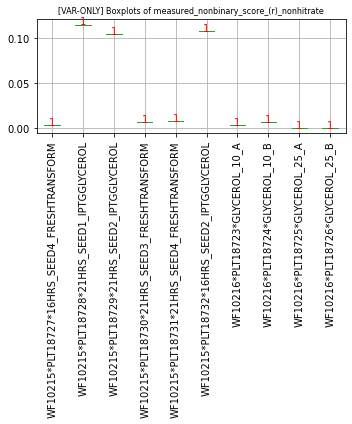

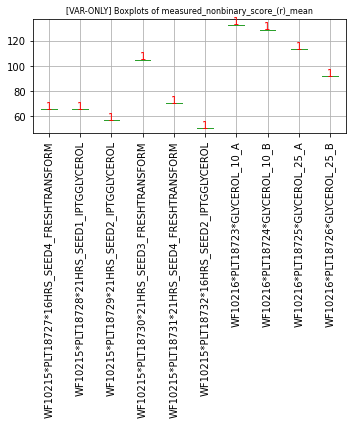

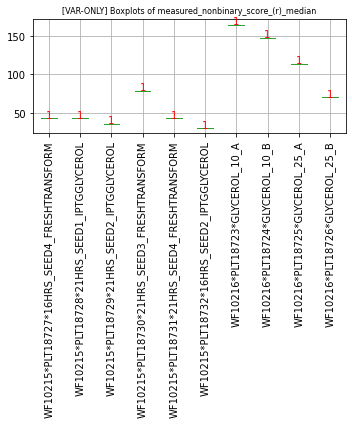

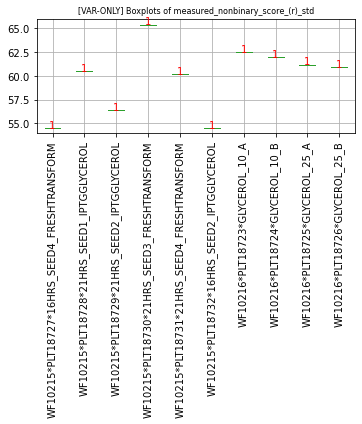

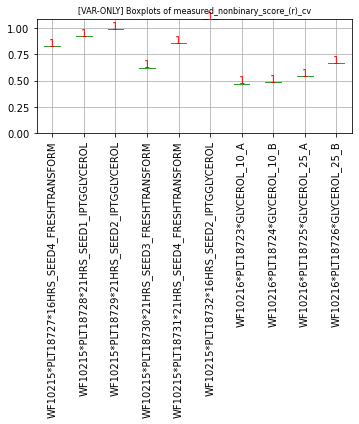

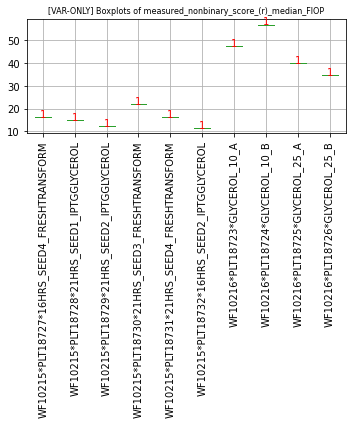

In [7]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
# REMOVE POSITIVE AND NEGATIVE CONTROLS
experiment_analytics_varonly = experiment_analytics.iloc[3:].copy()
experiment_analytics_varonly = experiment_analytics_varonly.loc[~experiment_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['workflow_plate_expcondition'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv', 'measured_nonbinary_score_(r)_median_FIOP']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV', 'RacemicProduct-FIOP']

# get boxplots, split by enzyme variant
# REMOVE NEGATIVE CONTROLS
experiment_analytics_noEV = experiment_analytics.iloc[3:].copy()
experiment_analytics_noEV = experiment_analytics_noEV.loc[~experiment_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    ylim = None
    if metric=='measured_nonbinary_score_(r)_cv':
        ylim = [0,min(2, experiment_analytics_noEV[metric].max())]
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['workflow_plate_expcondition'],
        fname_prefix='VAR-ONLY_',
        ylim=ylim
    )

## Get individual boxplots of exp conditions within each variant

DNA10001
Saved VQ-all-expts/BOXPLOT_DNA10001_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ10045
Saved VQ-all-expts/BOXPLOT_ENZ10045_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ11912
Saved VQ-all-expts/BOXPLOT_ENZ11912_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ12203
Saved VQ-all-expts/BOXPLOT_ENZ12203_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ12328
Saved VQ-all-expts/BOXPLOT_ENZ12328_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ12362
Saved VQ-all-expts/BOXPLOT_ENZ12362_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ12714
Saved VQ-all-expts/BOXPLOT_ENZ12714_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ13280
Saved VQ-all-expts/BOXPLOT_ENZ13280_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ13297
Saved VQ-all-expts/BOXPLOT_ENZ13297_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ16228
Saved VQ-all-expts/BOXPLOT_ENZ16228_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ22286
S

/Users/charmaine/Documents/projects/analytics_utils/analytics_utils/visualization_tools/visualization_utils.py:263: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(max(4,0.5*grp_len),6))


Saved VQ-all-expts/BOXPLOT_ENZ33334_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33351
Saved VQ-all-expts/BOXPLOT_ENZ33351_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33375
Saved VQ-all-expts/BOXPLOT_ENZ33375_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33392
Saved VQ-all-expts/BOXPLOT_ENZ33392_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33394
Saved VQ-all-expts/BOXPLOT_ENZ33394_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33409
Saved VQ-all-expts/BOXPLOT_ENZ33409_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33431
Saved VQ-all-expts/BOXPLOT_ENZ33431_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33433
Saved VQ-all-expts/BOXPLOT_ENZ33433_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33436
Saved VQ-all-expts/BOXPLOT_ENZ33436_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33441
Saved VQ-all-expts/BOXPLOT_ENZ33441_RacemicProduct_workflow_plate_expcondition.png to S3.
ENZ33459
Saved VQ-a

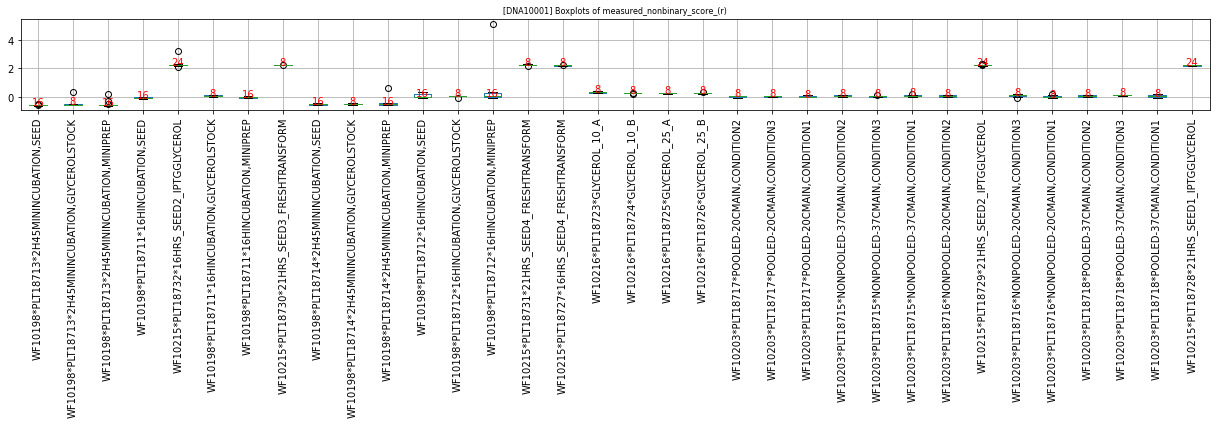

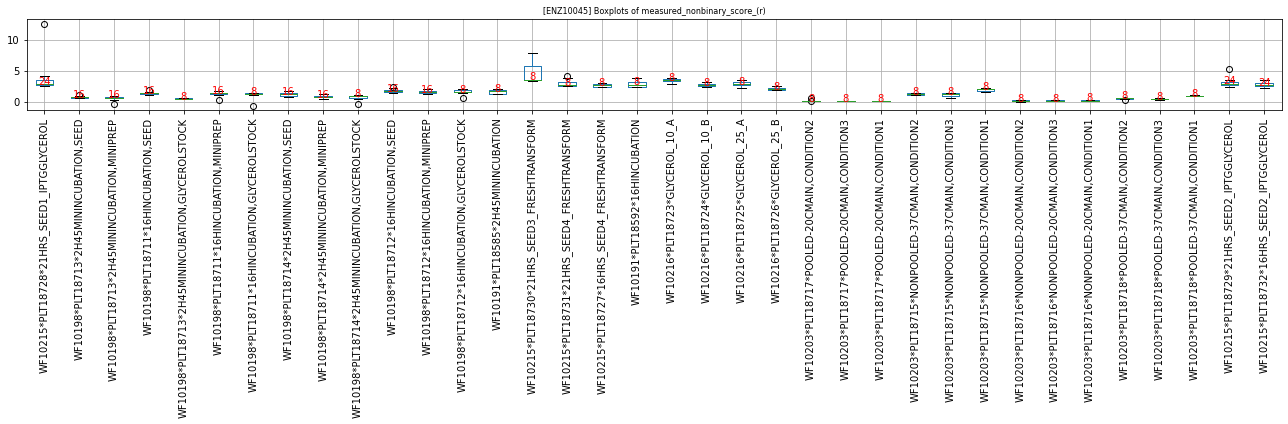

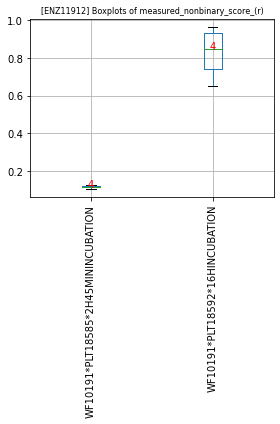

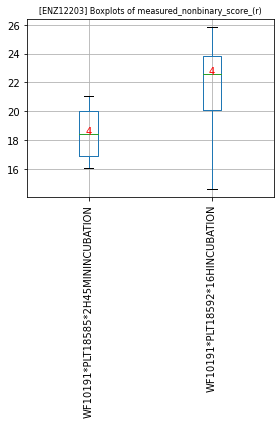

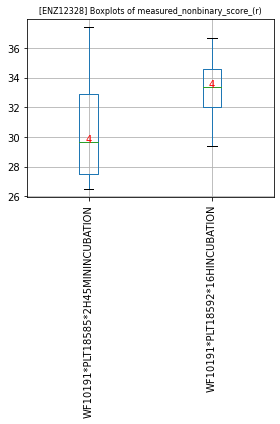

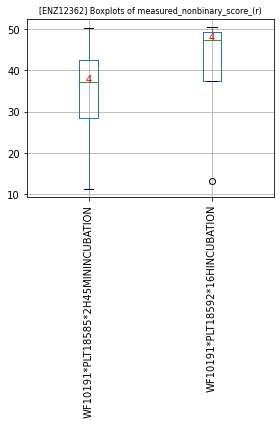

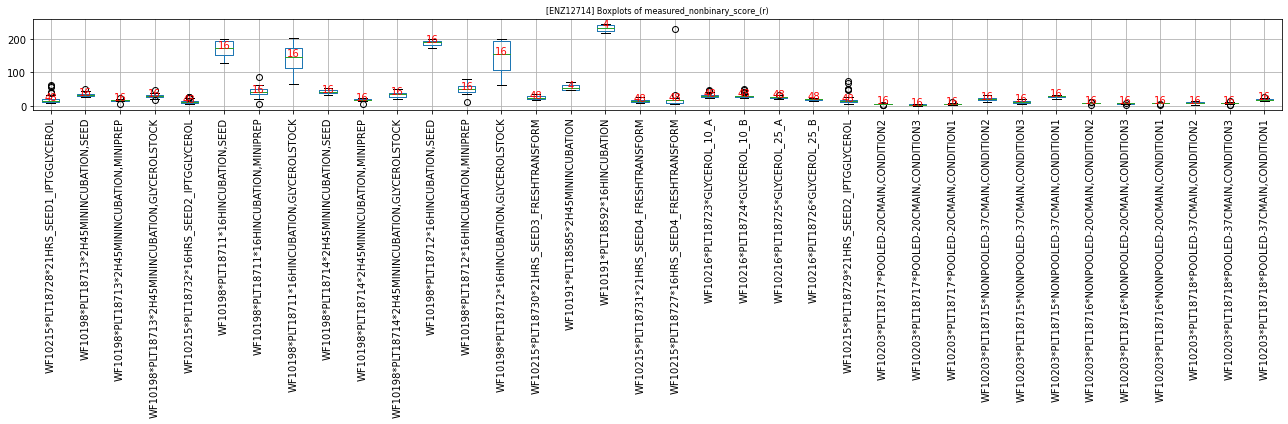

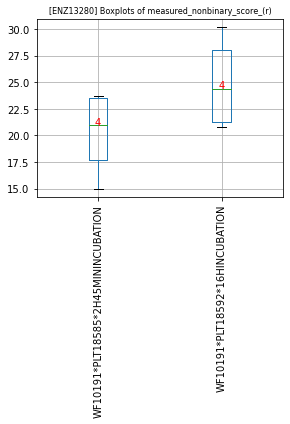

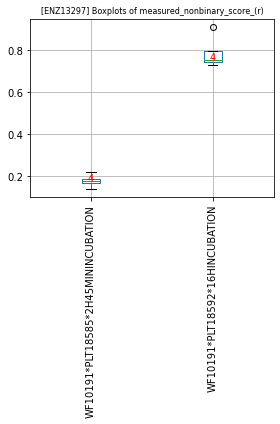

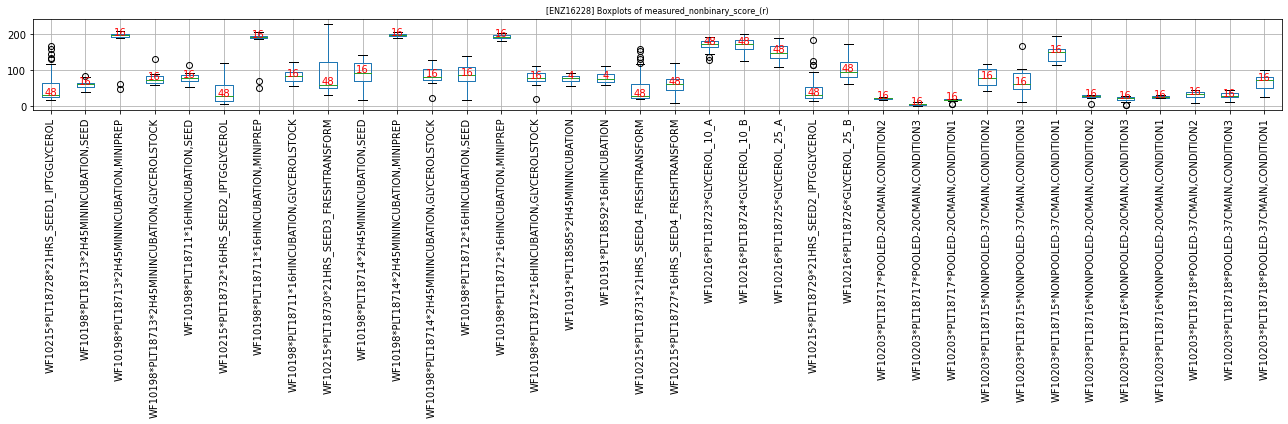

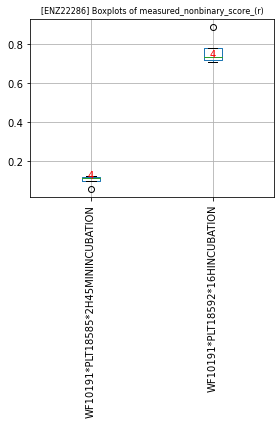

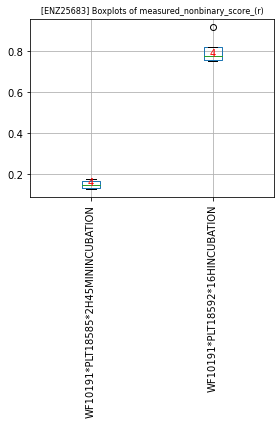

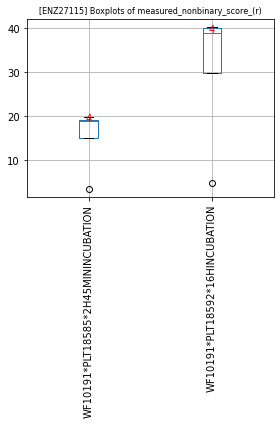

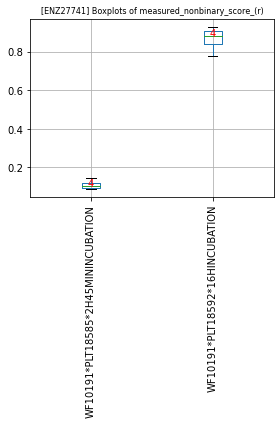

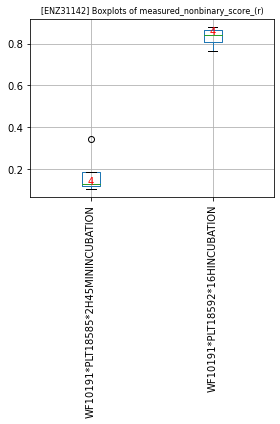

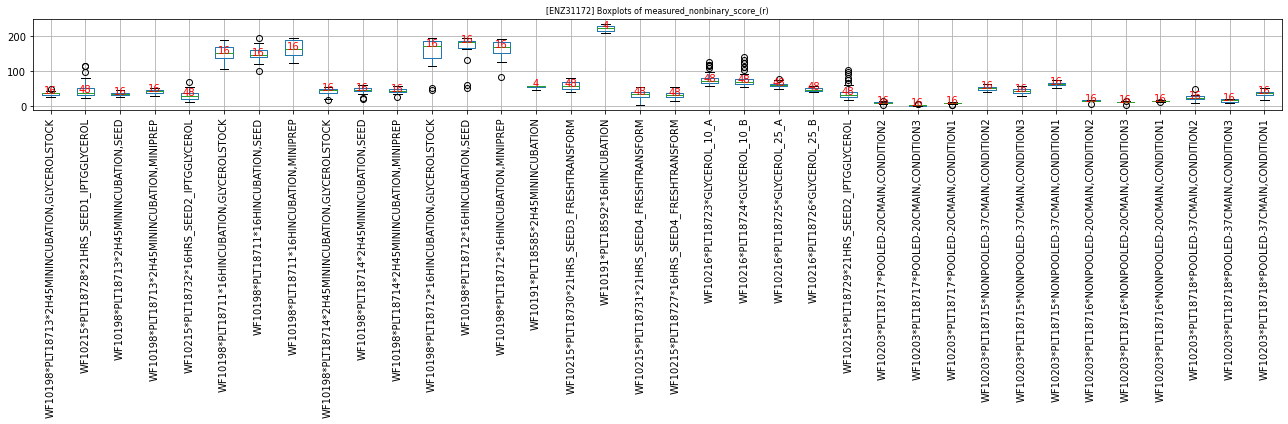

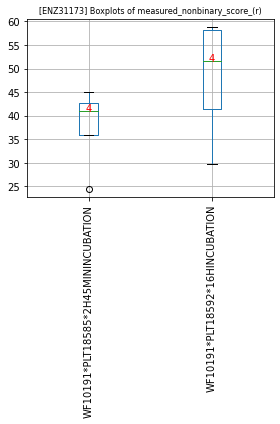

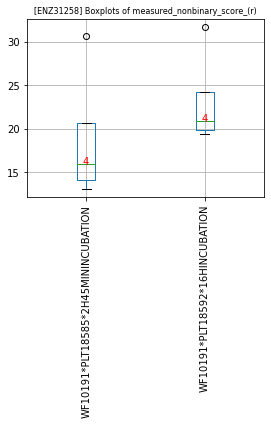

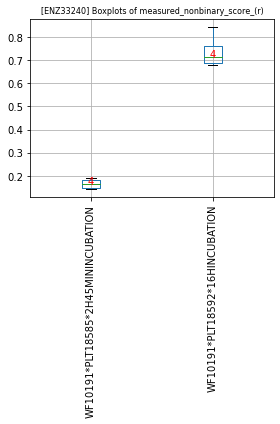

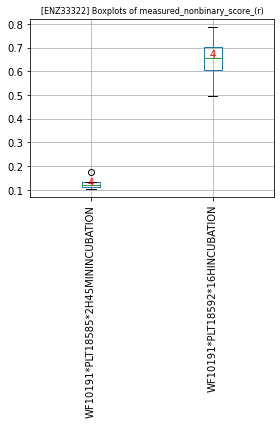

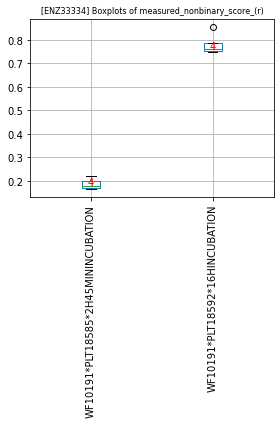

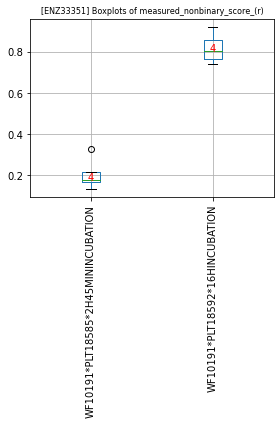

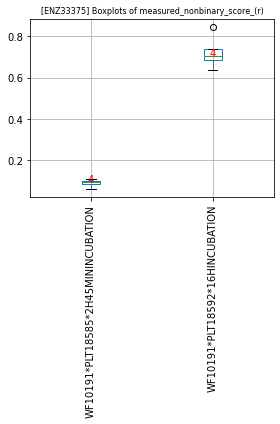

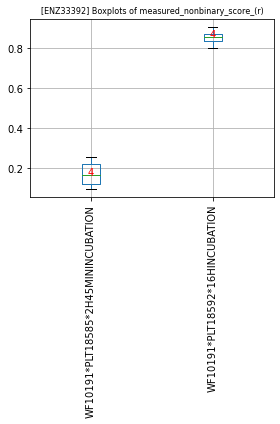

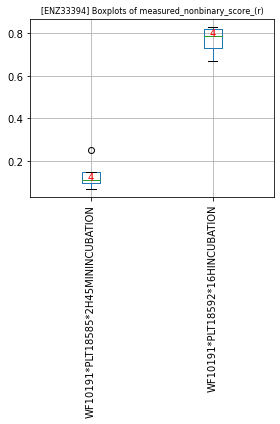

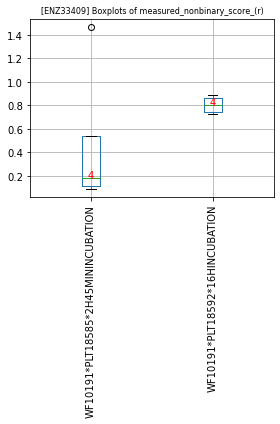

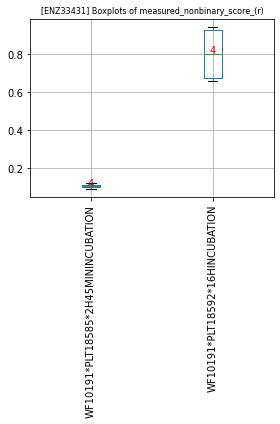

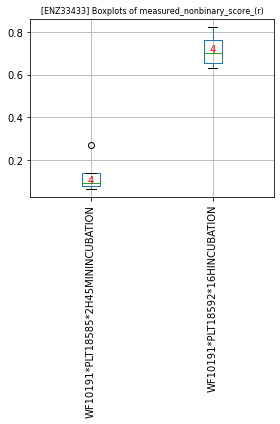

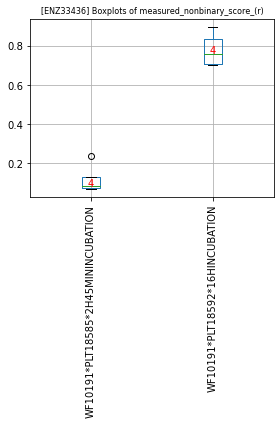

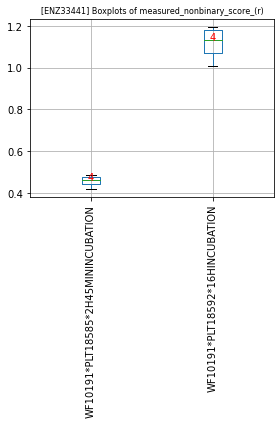

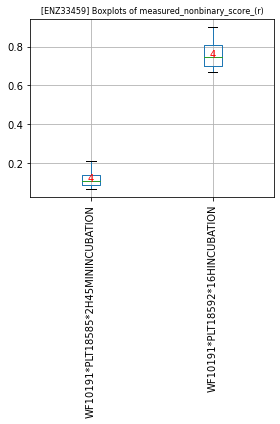

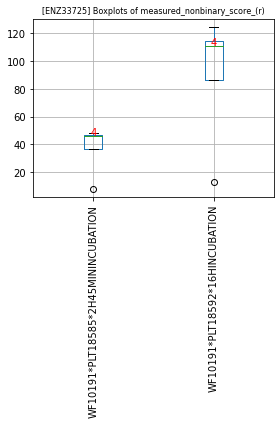

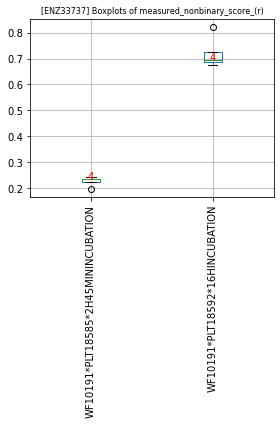

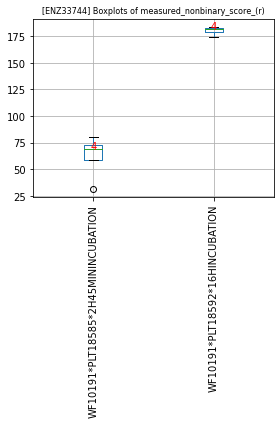

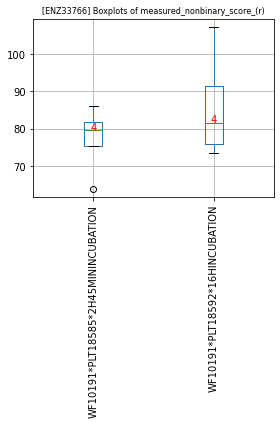

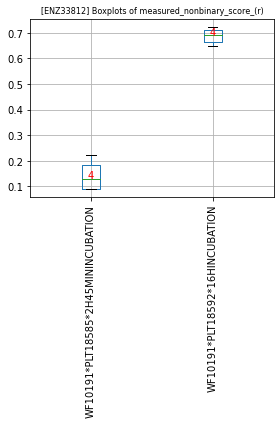

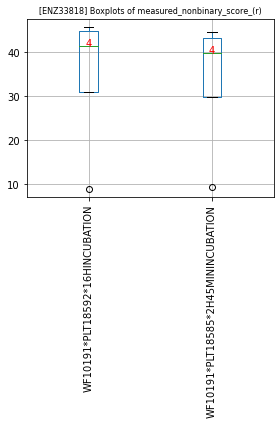

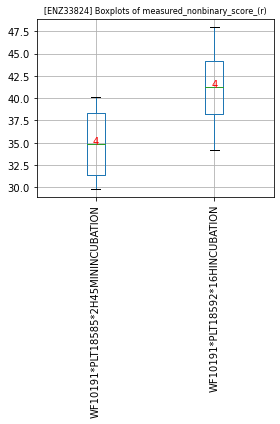

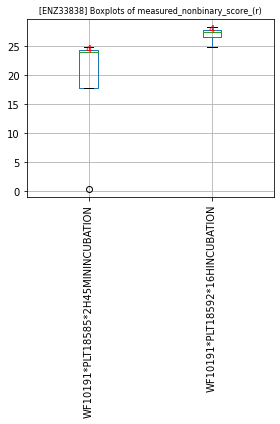

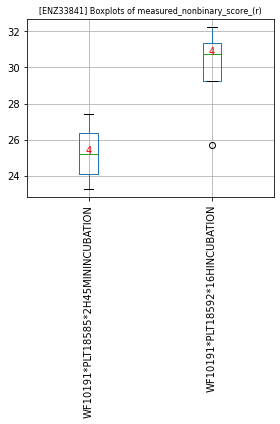

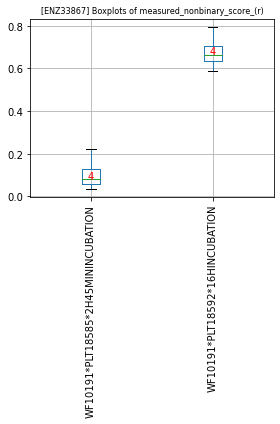

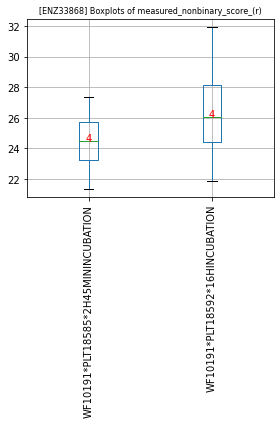

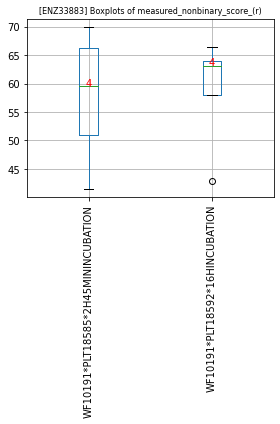

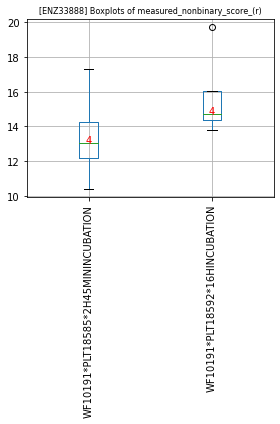

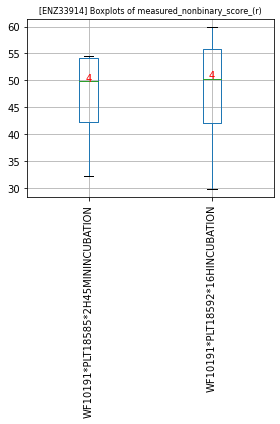

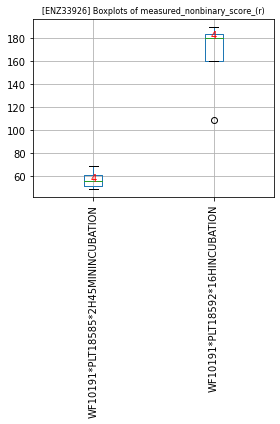

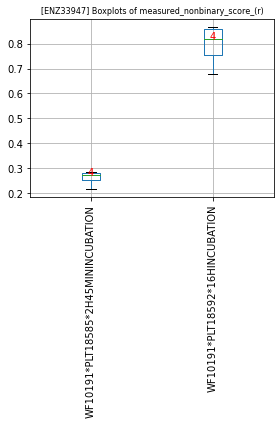

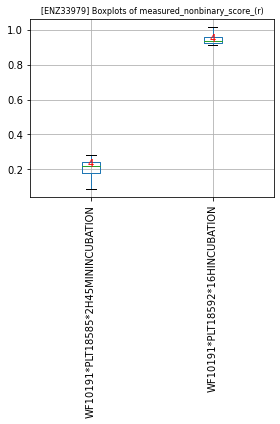

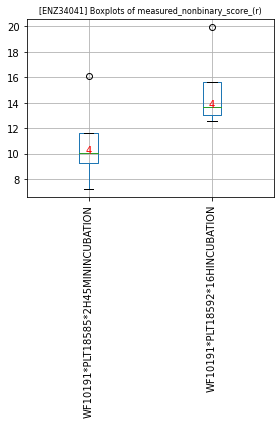

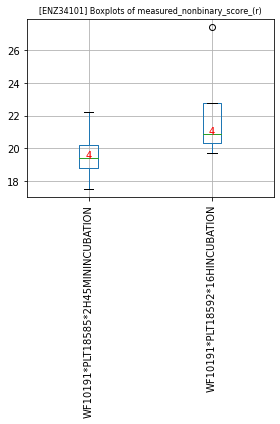

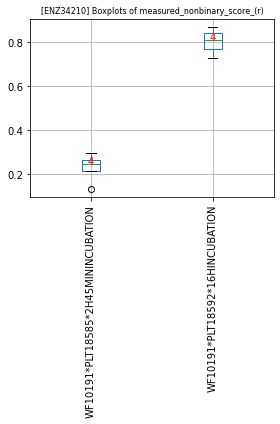

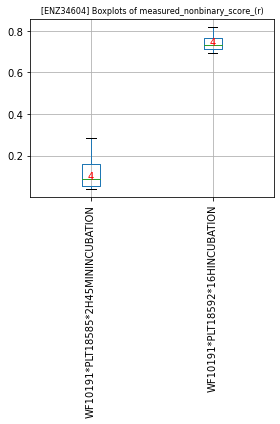

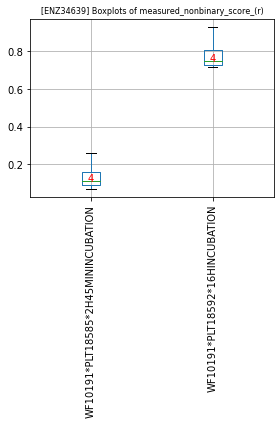

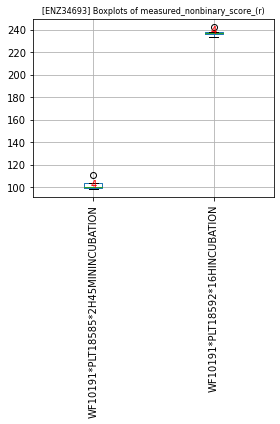

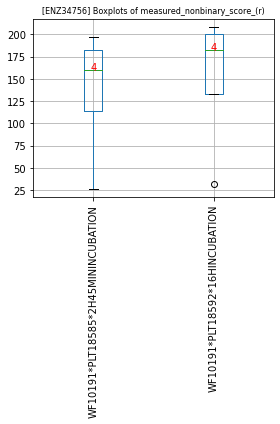

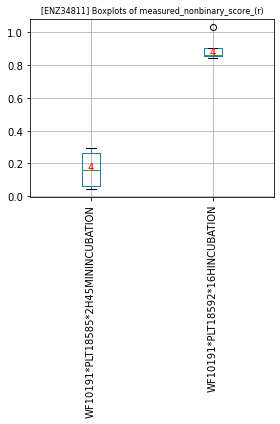

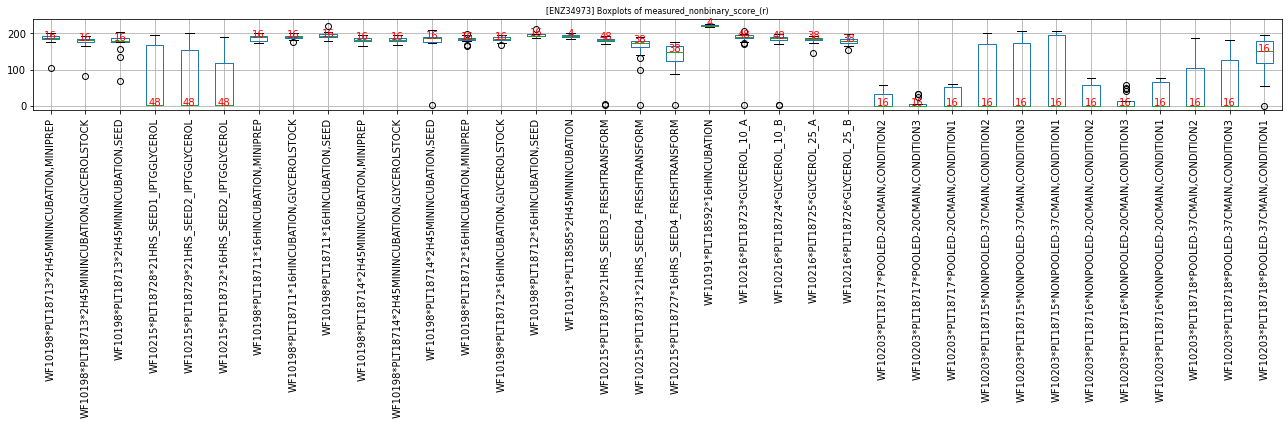

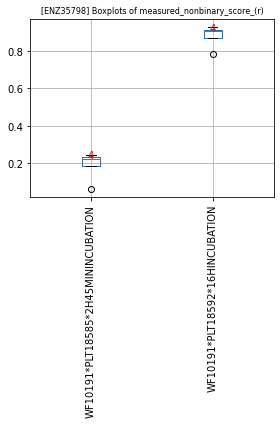

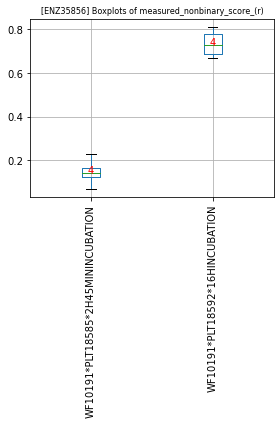

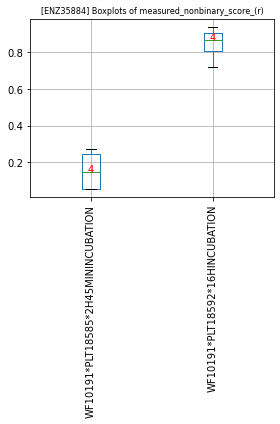

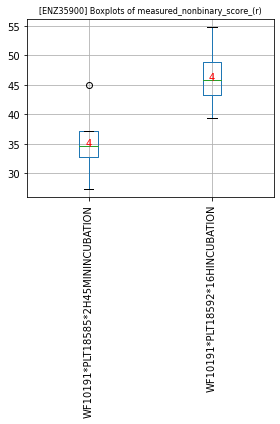

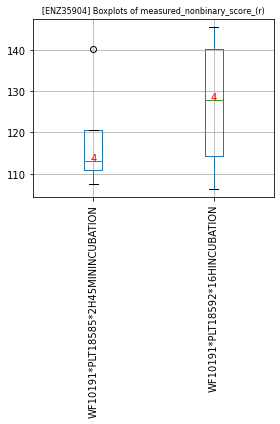

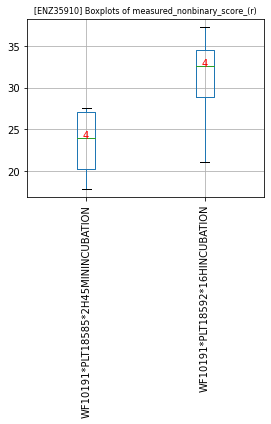

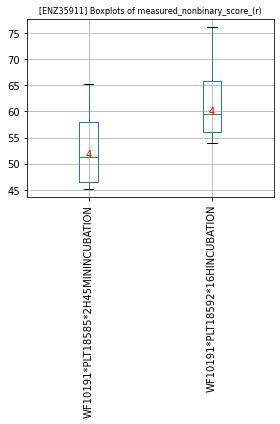

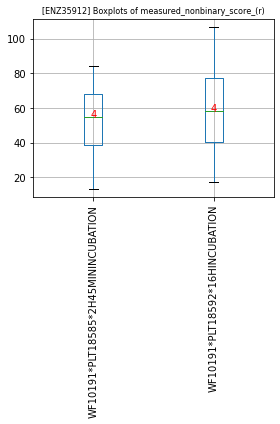

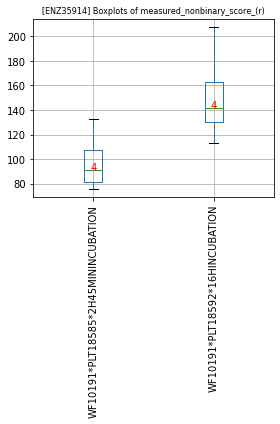

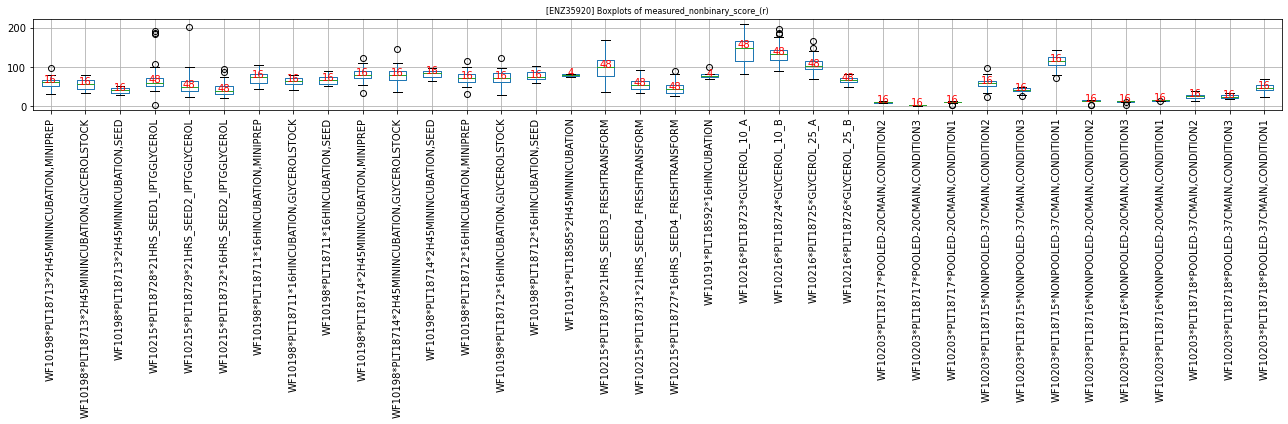

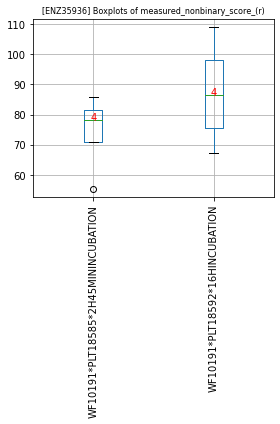

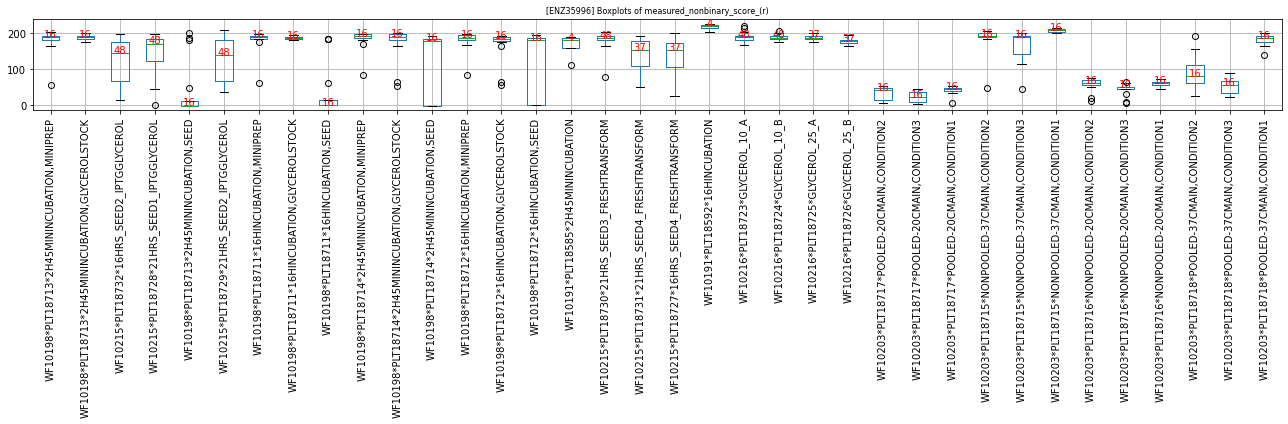

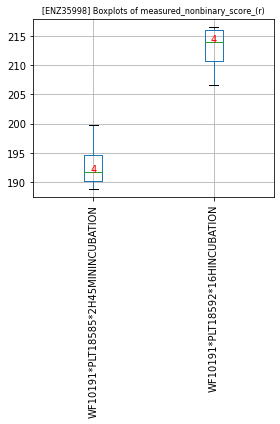

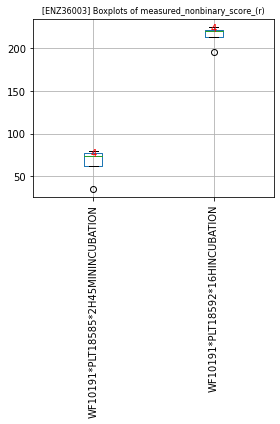

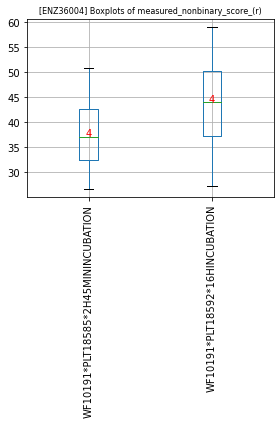

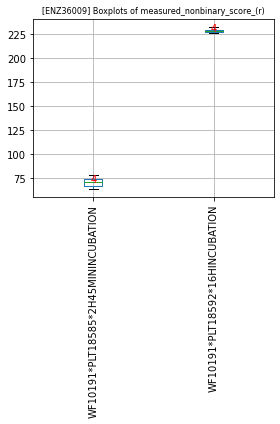

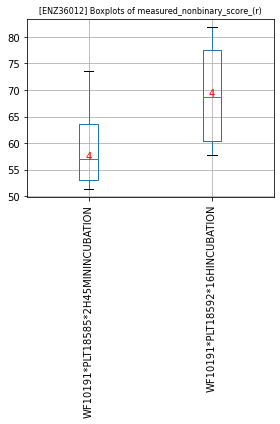

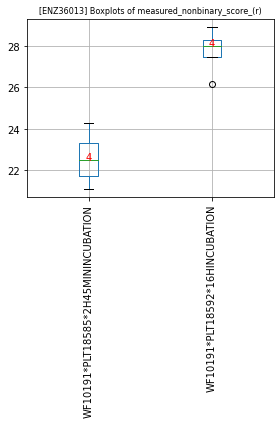

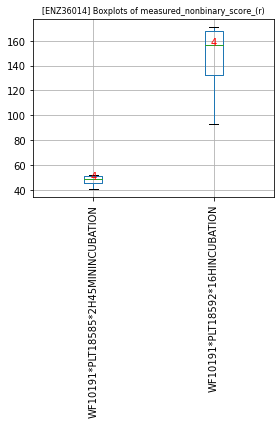

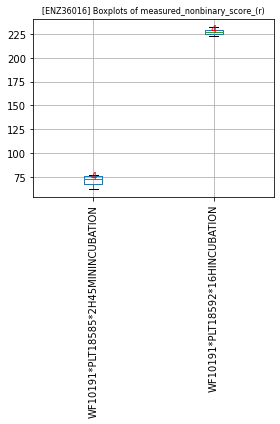

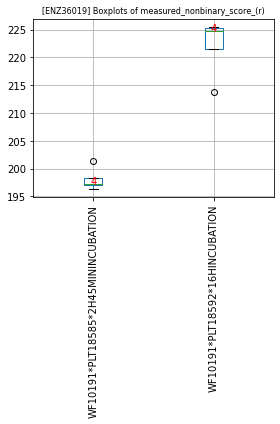

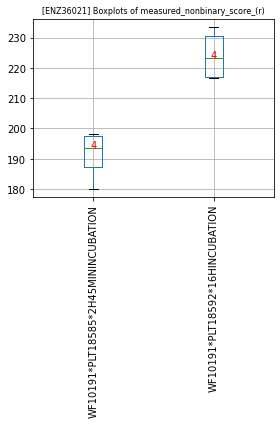

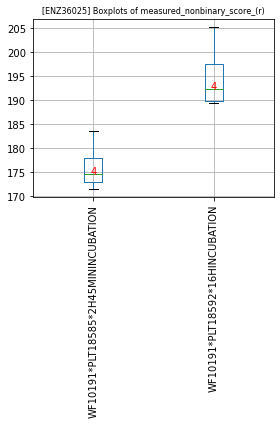

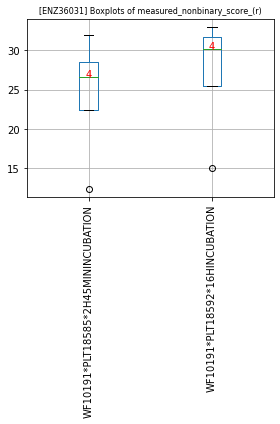

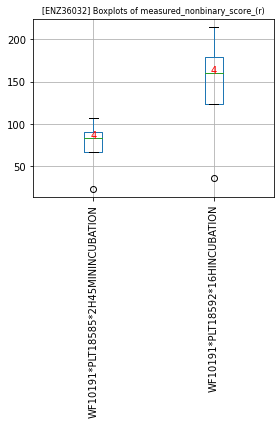

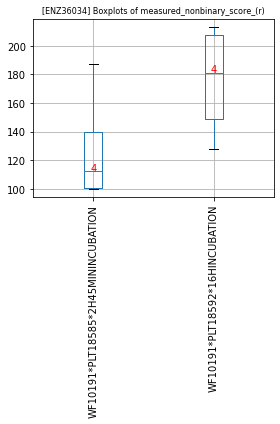

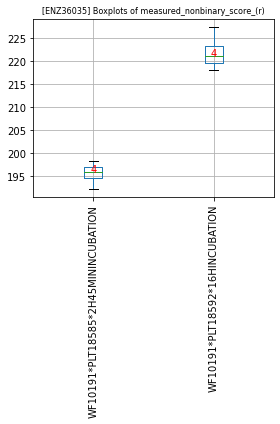

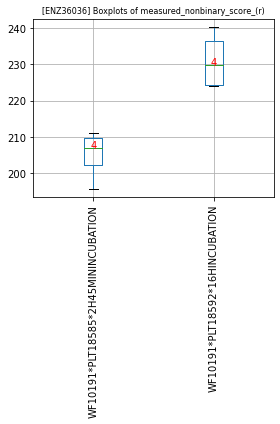

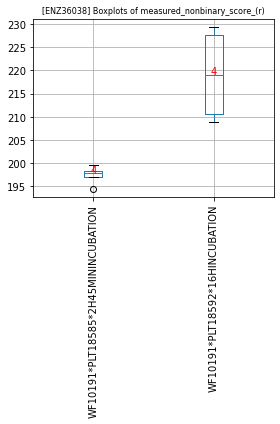

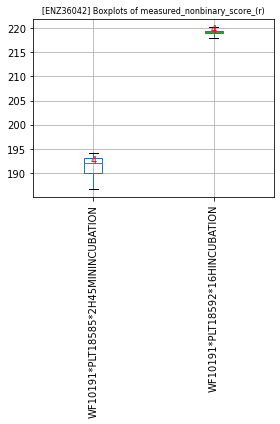

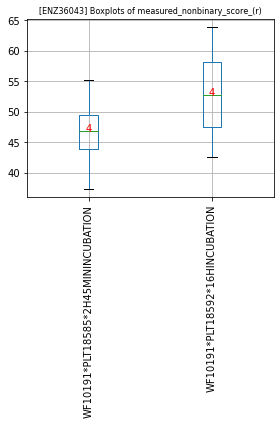

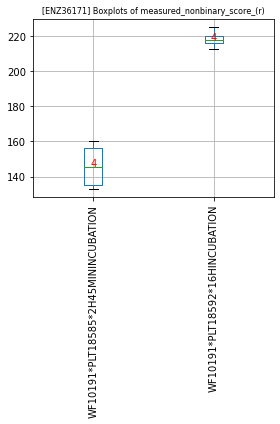

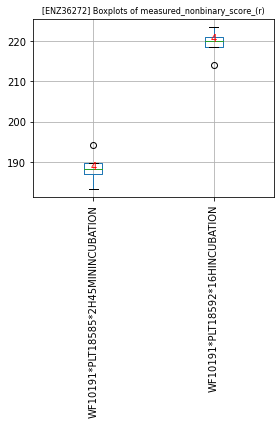

In [69]:
enz_list = sorted([enz for enz in list(set(df.enzyme_barcode)) if enz is not None])
metric_list=['measured_nonbinary_score_(r)'] # ['measured_nonbinary_score_(r)', 'pellet_OD'] # ['measured_nonbinary_score_(r)', 'measured_enantiomeric_excess_(+over-)']
metricname_list=['RacemicProduct'] # ['RacemicProduct', 'PelletOD']

# get boxplots, split by enzyme variant
for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    for enz in enz_list:
        print(enz)
        variant_reps = df.loc[df['enzyme_barcode']==enz]
        boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
            variant_reps, 
            metric_list=[metric],
            metricname_list=[metricname],
            groupby=['workflow_plate_expcondition'],
            fname_prefix=f'{enz}_'
        )

## Get scatter plots of Chiral metric vs. C18 metric

In [ ]:
# median values for each enzbarcode_expcondition, colorcoded by control type
analysis_pipeline.get_activity_correlation_scatterplots(
    experiment_analytics[3:], 
    xmetric_list=['measured_nonbinary_score_(r)_median'], 
    xmetricname_list=['RacemicProdConc-MEDIAN'], 
    ymetric='measured_enantiomeric_excess_(+over-)_median', 
    ymetricname='ChiralEE-MEDIAN', 
    groupby='ctrl_type_0', 
    table_suffix='', 
    showlegend=True
)

# invidual sample values, color coded by enzyme barcode
analysis_pipeline.get_activity_correlation_scatterplots(
    df, 
    xmetric_list=['measured_nonbinary_score_(r)'], 
    xmetricname_list=['RacemicProdConc'], 
    ymetric='measured_enantiomeric_excess_(+over-)', 
    ymetricname='ChiralEE', 
    groupby='enzyme_barcode', 
    table_suffix='', 
    showlegend=False
)

## Get scatter plots of C18 metric vs. PelletOD

Saved VQ-IPTGexp/SCATTERPLOT_RacemicProdConc-vs-PelletOD_enzyme_barcode.png to S3.


[<Figure size 360x360 with 1 Axes>]

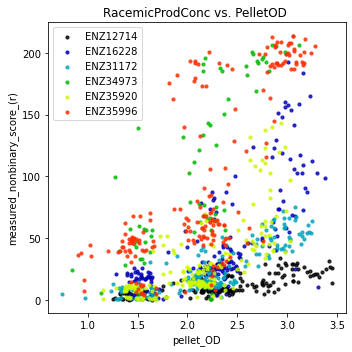

In [38]:
# invidual sample values, color coded by enzyme barcode
analysis_pipeline.get_activity_correlation_scatterplots(
    df, 
    xmetric_list=['pellet_OD'], 
    xmetricname_list=['PelletOD'], 
    ymetric='measured_nonbinary_score_(r)', 
    ymetricname='RacemicProdConc', 
    groupby='enzyme_barcode', 
    table_suffix='', 
    showlegend=True
)

# Get Analytics Dashboard

## Save dashboard contents to S3

In [24]:
# pickle analysis pipeline s3 folder
filename = f'{s3_subfolder}dashboard_contents.pkl'

# SAVE DASHBOARD CONTENTS
upload_to_s3(s3_bucket, filename, analysis_pipeline.dashboard_contents)  

# # LOAD MODEL
# dashboard_contents_unpickled = download_from_s3(s3_bucket, filename)
# print(dashboard_contents_unpickled)

## Initialize Analytics Pipeline object & get panel columns

In [ ]:
s3_subfolder = f'VQ-Retest5/' 
exp_workflow = ['WF10198']
table = 'combi_analytics_table' # 'lcms_detections' # 
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    get_dashboard_panel=False,
    save_plots_to_s3=True
)

# fetch panel columns
panel_columns = analysis_pipeline.fetch_saved_panel_data()

In [ ]:
pn.template.FastListTemplate(
    site="Panel", 
    title=f"{s3_subfolder}Dev Analytics", 
    main=panel_columns, 
    main_max_width="1760px",
)#.servable();

# Manual Analysis

## Comparison to Phoenix Data

In [56]:
exp_workflow_phnx = ['WF10125','WF10128','WF10130','WF10132', 'WF10134', 'WF10136', 'WF10139', 'WF10144', 'WF10149', 'WF10157', 'WF10158', 'WF10163', 'WF10169', 'WF10173', 'WF10181']  # None # 
df_phnx = analysis_pipeline.load_data(table, exp_workflow=exp_workflow_phnx)
enz_list_varonly = [enz for enz in list(set(enz_list)) if enz not in ['DNA10001', 'ENZ10045']]
df_phnx_varonly = df_phnx.loc[df_phnx.enzyme_barcode.isin(enz_list_varonly)].reset_index(drop=True)

executing query: SELECT "id", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "maldi_run", "lcms_C18_run", "lcms_chiral_run", "maldi_plate_(r)", "maldi_address_(r)", "lcms_plate_(r)", "lcms_address_(r)", "source_plate_(r)", "source_address_(r)", "maldi_plate_(+)", "maldi_address_(+)", "lcms_plate_(+)", "lcms_address_(+)", "source_plate_(+)", "source_address_(+)", "maldi_plate_(-)", "maldi_address_(-)", "lcms_plate_(-)", "lcms_address_(-)", "source_plate_(-)", "source_address_(-)", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "mutations", "hamming", "reference_enzyme", "substrate_barcode_(r)", "substrate_barcode_(+)", "substrate_barcode_(-)", "substrate_smiles_(r)", "substrate_smiles_(+)", "substrate_smiles_(-)", "substrate_concentration_(r)", "substrate_concentration_(+)", "substrate_concentration_(-)", "predicted_binary_score_(r)", "predicted_nonbinary_score_(r)", "measured_nonbinary_score_(r)", "measured_nonbinary_sum_(r)", "measured_conversio

In [60]:
# combine Retest 5 and Phoenix dataset
df_all = pd.concat([df_phnx_varonly, df]).reset_index(drop=True)

# replace NaN exp_condition values with ''
df_all.loc[df_all.exp_condition.isnull(), 'exp_condition'] = ''

In [ ]:
from utils.visualization_utils import plot_boxplot

for enz in enz_list_varonly:
    print(enz)
    df_enz = df_all.loc[df_all.enzyme_barcode==enz]
    boxplot_list_enz = plot_boxplot(df_enz, ['measured_nonbinary_score_(r)'], groupby=['exp_workflow_barcode', 'exp_condition'], showplot=True, show_n=True)